<a href="https://colab.research.google.com/github/pyagoubi/Credit-Default-Prediction/blob/main/Amex_XGBoost_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
################### Installing RAPIDS on colab
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
!pip install pynvml

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

In [2]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#set WD
import os
os.chdir('/content/drive/MyDrive/Amex/parquet')

# XGBoost 


# Load Libraries

In [4]:
# LOAD LIBRARIES
import pandas as pd, numpy as np # CPU libraries
import cupy, cudf # GPU libraries
import matplotlib.pyplot as plt, gc, os

from sklearn.model_selection import KFold
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import csv, itertools

from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.inspection import permutation_importance


print('RAPIDS version',cudf.__version__)

RAPIDS version 21.12.02


In [5]:
# VERSION NAME FOR SAVED MODEL FILES
VER = 2

# TRAIN RANDOM SEED
SEED = 42

# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

# FOLDS PER MODEL
FOLDS = 5

NUM_PARTS = 4


TRAIN_PATH = 'train.parquet'
TEST_PATH = 'test.parquet'
TARGET_PATH = 'train_labels.csv'
SAVE_PATH = '/content/drive/MyDrive/Amex/parquet/XGB final/'
SUBMISSION_FILE_PATH = '/content/drive/MyDrive/Amex/parquet/sample_submission.csv'

# Process and Feature Engineer Train Data

In [6]:
def read_file(path = '', usecols = None):
    # LOAD DATAFRAME
    if usecols is not None: df = cudf.read_parquet(path, columns=usecols)
    else: df = cudf.read_parquet(path) #df = cudf.read_parquet(path)
    # REDUCE DTYPE FOR CUSTOMER AND DATE
    df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    df.S_2 = cudf.to_datetime( df.S_2 )
    #df.S_2 = pd.to_datetime( df.S_2 )
    print('shape of data:', df.shape)
    
    return df

def to_pd(df):
  df = df.to_pandas()
  return df

def to_cu(df):
  df = cudf.from_pandas(df)
  return df

def revertnan(df):
  #df = df.to_pandas()
  df[df==-1] = np.nan 
  #df = cudf.from_pandas(df)
  return df

def fill_na(df, NAN_VALUE):
  df = df.fillna(NAN_VALUE)
  return df

def numberobs_feature(df):
  #df = df.to_pandas()
  df['number_of_observations'] = df.groupby('customer_ID')['customer_ID'].transform('count')
  df.loc[df['B_33'].isnull() & (df.number_of_observations==1),'number_of_observations'] = 0.5
  #df = cudf.from_pandas(df)
  return df

def afterpay(df):
  # compute "after pay" features
  for bcol in [f'B_{i}' for i in [11,14,17]]+['D_39','D_131']+[f'S_{i}' for i in [16,23]]:
    for pcol in ['P_2','P_3']:
      if bcol in df.columns:
        df[f'{bcol}-{pcol}'] = df[bcol] - df[pcol]
  return df

def get_features(df):
  all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
  cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
  num_features = [col for col in all_cols if col not in cat_features]
  return all_cols, cat_features, num_features

def agg_functions(df, num_features, cat_features, numberobs = False#, exclnullCols, 
                  #dummy_nan_col
                  ):
  
  test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'max', 'min', 'first', 'last'])

  #test_nan_agg = df.groupby("customer_ID")[exclnullCols].agg(['last'])
  ##dummy_nan_col_agg = df.groupby("customer_ID")[dummy_nan_col].agg(['sum'])
  #df_presence_agg = df.groupby("customer_ID")['number_of_observations'].agg(['last'])
  
  test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])


  df = cudf.concat([test_num_agg, test_cat_agg],   #dummy_nan_col_agg, 
                   # test_nan_agg], 
                   axis=1)
  
  df.columns = ['_'.join(x) for x in df.columns]

  if numberobs ==True:
    to_drop = ['number_of_observations_mean', 'number_of_observations_std', 'number_of_observations_max','number_of_observations_min', 'number_of_observations_first']
    df.drop(to_drop, axis = 1, inplace = True)
    df.rename(columns={'number_of_observations_last':'number_of_observations'}, inplace = True)

  del test_num_agg, test_cat_agg
  _ = gc.collect()
  print('shape after engineering', df.shape )
  return df

def add_meandev(df, num_features):
  df = df.to_pandas()
  
  for i in [f for f in num_features if f not in ['number_of_observations']]:
    first = f'{i}_first'
    last = f'{i}_last'
    min = f'{i}_min'
    max = f'{i}_max' 
    mean = f'{i}_mean' 
    # diff = df[last] - df[first]
    # df[f'{i}_pctchange'] = np.nan
    # df.loc[(df[last]<0) & (df[first]<0) & ((df[last] - df[first]) > 0), f'{i}_pctchange'] = ((df[last] - df[first])/df[first])*-1*100/df['number_of_observations']
    # df.loc[(df[last]<0) & (df[first]<0) & ((df[last] - df[first]) < 0), f'{i}_pctchange'] = ((df[last] - df[first])/df[first])*-1*100/df['number_of_observations']
    # df.loc[(df[last]>0) & (df[first]<0), f'{i}_pctchange'] = (diff/df[first])*-1*100/df['number_of_observations']
    # df.loc[(df[last]<0) & (df[first]>0), f'{i}_pctchange'] = (diff/df[first])*100/df['number_of_observations']
    # df.loc[(df[last]>0) & (df[first]>0), f'{i}_pctchange'] = (diff/df[first])*100/df['number_of_observations']
    # df.loc[(df[last]==0) & (df[first]>0), f'{i}_pctchange'] = (diff/df[first])*100/df['number_of_observations']
    # df.loc[(df[last]==0) & (df[first]<0), f'{i}_pctchange'] = (diff/df[first])*-1*100/df['number_of_observations']
    # df.loc[(df[last]<0) & (df[first]==0), f'{i}_pctchange'] = 100/df['number_of_observations']
    # df.loc[(df[last]>0) & (df[first]==0), f'{i}_pctchange'] = -100/df['number_of_observations']

    # df[f'{i}_abschange'] = np.nan
    # df.loc[(df[last] != np.nan) & (df[first] != np.nan), f'{i}_abschange'] = (df[last] - df[first])#/df['number_of_observations']



    # df[f'{i}_minmax'] = np.nan
    # df.loc[(df[last] != np.nan) & (df[first] != np.nan), f'{i}_minmax'] = (df[max] - df[min])#/df['number_of_observations']
    df[f'{i}_meandev'] = np.nan
    df.loc[(df[last] != np.nan), f'{i}_meandev'] = df[last] -df[mean]



  df = cudf.from_pandas(df)
  return df

def dropfirst(df):
  df = df.to_pandas()
  droplist = list(df.loc[:, df.columns.str.contains('first')].columns)
  df.drop(droplist, axis = 1, inplace = True)
  df = cudf.from_pandas(df)
  print('shape after engineering', df.shape )
  return df

def add_targets(df, TARGET_PATH):
  # ADD TARGETS
  targets = cudf.read_csv(TARGET_PATH)
  targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
  targets = targets.set_index('customer_ID')
  df = df.merge(targets, left_index=True, right_index=True, how='left')
  df.target = df.target.astype('int8')
  del targets

  # NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
  df = df.sort_index().reset_index()
  return df

In [7]:
#all functions compact
def preprocess(PATH = TRAIN_PATH, TARGET_PATH = TARGET_PATH, train_set = True, test = None):
  if train_set == True:
    df = read_file(path = TRAIN_PATH)
  else:
    df = test
  df = to_pd(df)
  df = revertnan(df)
  df = numberobs_feature(df)
  df = to_cu(df)
  df = afterpay(df)
  all_cols, cat_features, num_features = get_features(df)
  #df = to_cu(df)
  df = agg_functions(df, num_features, cat_features, numberobs = True)
  df = add_meandev(df, num_features)
  df = fill_na(df, NAN_VALUE)
  df = dropfirst(df)
  if train_set == True:
    df = add_targets(df, TARGET_PATH)
  return df

In [8]:
train = preprocess(PATH = TRAIN_PATH)

shape of data: (5531451, 190)
shape after engineering (458913, 1180)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


shape after engineering (458913, 1180)


In [9]:
#del train
gc.collect()
#train['number_of_observations']

151

In [10]:
def get_feature_list(df):
  features = df.columns[1:-1]
  print(f'There are {len(features)} features!')
  return features

In [11]:
features = get_feature_list(train)

There are 1180 features!


In [ ]:
train['number_of_observations']

In [ ]:
train[['D_131_last','D_131_meandev']]

Train XGB

In [12]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [13]:
def get_xgb_parameters():
  # XGB MODEL PARAMETERS
  xgb_parms = { 
    'max_depth':4, 
    'learning_rate':0.05, 
    'subsample':0.8,
    'colsample_bytree':0.6, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
  }
  return xgb_parms

In [14]:
xgb_parms = get_xgb_parameters()

In [15]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [16]:
train = train.to_pandas()

In [21]:
def train_model(df, SEED=SEED, SAVE_PATH =SAVE_PATH, VER=VER):
  importances = []
  oof = []
  TRAIN_SUBSAMPLE = 1.0
  gc.collect()

  skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
  for fold,(train_idx, valid_idx) in enumerate(skf.split(
            df, df.target )):
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    Xy_train = IterLoadForDMatrix(train.loc[train_idx], features, 'target')
    X_valid = df.loc[valid_idx, features]
    y_valid = df.loc[valid_idx, 'target']
    
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'{SAVE_PATH}XGB_v{VER}_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df_pred = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df_pred)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_valid.values, oof_preds)
    print('Kaggle Metric =',acc,'\n')
    
    # SAVE OOF
    df_pred = df.loc[valid_idx, ['customer_ID','target'] ].copy()
    df_pred['oof_pred'] = oof_preds
    oof.append( df_pred )
    
    del dtrain, Xy_train, dd, df_pred
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    
  print('#'*25)
  oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
  acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
  print('OVERALL CV Kaggle Metric =',acc)

In [20]:
train_model(train)

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100% fold data...
#########################
[0]	train-logloss:0.66189	valid-logloss:0.66192
[100]	train-logloss:0.23478	valid-logloss:0.23761
[200]	train-logloss:0.22119	valid-logloss:0.22638
[300]	train-logloss:0.21529	valid-logloss:0.22262
[400]	train-logloss:0.21117	valid-logloss:0.22060
[500]	train-logloss:0.20790	valid-logloss:0.21943
[600]	train-logloss:0.20514	valid-logloss:0.21865
[700]	train-logloss:0.20259	valid-logloss:0.21802
[800]	train-logloss:0.20022	valid-logloss:0.21763
[900]	train-logloss:0.19793	valid-logloss:0.21736
[1000]	train-logloss:0.19579	valid-logloss:0.21707
[1100]	train-logloss:0.19375	valid-logloss:0.21689
[1200]	train-logloss:0.19176	valid-logloss:0.21670
[1300]	train-logloss:0.18983	valid-logloss:0.21664
[1400]	train-logloss:0.18794	valid-logloss:0.21653
[1500]	train-logloss:0.18610	valid-logloss:0.21646
[1600]	train-logloss:0.18426	valid-logloss:0.21642
[1700]	



```
base = 0.791536
ohne na Behandlung = 0.790870
na fill nach agg = 0.7916640
revertnan und na_fill nach agg = 0.791823
mit number of obs (und na_fill nach agg) = 0.79223834
so mit growth feature = 0.79185923 ??
mit abschange = 0.7917617 ??
mit abschange nicht skaliert = 0.791859 ?
number of obs in buckets (größer 10) + abschange = 0.7915386 ?
mit number_of_obs und min-max = 0.792181
mit number of obs (und na_fill nach agg)fillna vor meandev + mean deviation = 0.792464
mit number of obs (und na_fill nach agg) fillna nach meandev + mean deviation = 0.79237036




In [ ]:
gc.collect()

88

In [ ]:
del train

Prepare Testdata

In [26]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

In [49]:
def get_rowsnumcust(TEST_PATH, NUM_PARTS=NUM_PARTS):
  print(f'Reading test data...')
  test = read_file(path = TEST_PATH, usecols = ['customer_ID','S_2'])
  customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
  rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')
  return rows,num_cust,customers

In [45]:
def infer_test(rows,num_cust,customers, VER=VER,features=features, SUBMISSION_FILE_PATH = SUBMISSION_FILE_PATH ):
  # INFER TEST DATA IN PARTS
  skip_rows = 0
  skip_cust = 0
  test_preds = []

  for k in range(NUM_PARTS):
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test = read_file(path = TEST_PATH)
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    test = preprocess(train_set = False, test = test) 
    if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
    else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    
    # TEST DATA FOR XGB
    X_test = test[features]
    dtest = xgb.DMatrix(data=X_test)
    test = test[['P_2_mean']] # reduce memory
    del X_test
    gc.collect()

    # INFER XGB MODELS ON TEST DATA
    model = xgb.Booster()
    model.load_model(f'{SAVE_PATH}XGB_v{VER}_fold0.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'{SAVE_PATH}XGB_v{VER}_fold{f}.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del dtest, model
    _ = gc.collect()

  test_preds = np.concatenate(test_preds)
  test = cudf.DataFrame(index=customers,data={'prediction':test_preds})
  sub = cudf.read_csv(SUBMISSION_FILE_PATH)[['customer_ID']]
  sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
  sub = sub.set_index('customer_ID_hash')
  sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
  sub = sub.reset_index(drop=True)

  sub.to_csv(f'{SAVE_PATH}submission_xgb_v{VER}.csv',index=False)
  print('Submission file shape is', sub.shape )
  sub.head()

In [48]:
def test_pred():
  rows,num_cust, customers = get_rowsnumcust(TEST_PATH, NUM_PARTS=NUM_PARTS)
  infer_test(rows=rows,num_cust=num_cust, customers=customers)


In [50]:
test_pred()

Reading test data...
shape of data: (11363762, 2)
We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[2841209, 2839857, 2842105, 2840591]

Reading test data...
shape of data: (11363762, 190)
=> Test part 1 has shape (2841209, 190)
shape after engineering (231155, 1096)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


shape after engineering (231155, 1096)

Reading test data...
shape of data: (11363762, 190)
=> Test part 2 has shape (2839857, 190)
shape after engineering (231155, 1096)
shape after engineering (231155, 1096)

Reading test data...
shape of data: (11363762, 190)
=> Test part 3 has shape (2842105, 190)
shape after engineering (231155, 1096)
shape after engineering (231155, 1096)

Reading test data...
shape of data: (11363762, 190)
=> Test part 4 has shape (2840591, 190)
shape after engineering (231156, 1096)
shape after engineering (231156, 1096)
Submission file shape is (924621, 2)


### ENDE

In [ ]:
temp = cudf.DataFrame({'a':[1,2,3,4], 'b':[1,2,3,4]})
temp.groupby(['a']).size().sort_values('a')

NotImplementedError: ignored

In [ ]:
def number_of_obs(df):
  df_presence = df.groupby(['customer_ID']).size().reset_index().rename(columns={0:'number_of_observations'})
  df = df.merge(df_presence, on='customer_ID', how = 'left')
  df.loc[df['B_33'].isnull() & (df.number_of_observations==1),'number_of_observations'] = 0.5
  df_presence_agg = df.groupby("customer_ID")['number_of_observations'].agg(['last'])
  df_presence_agg.columns = ['_'.join(x) for x in df_presence_agg.columns]
  gc.collect()
  return df

In [ ]:
train = number_of_obs(train)

In [ ]:
def revertnan(df):
  df = df.to_pandas()
  df[df==-1] = np.nan 
  df = cudf.from_pandas(df)
  return df

In [ ]:
train = revertnan(train)

In [ ]:
def dummy_nan(df):

  all_cols = [c for c in list(train.columns) if c not in ['customer_ID','S_2']]
  cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
  num_features = [col for col in all_cols if col not in cat_features]

  nullvals = df.isnull().sum() / df.shape[0]

  #keep only last für nan >90%
  exclnullCols = nullvals[nullvals>0.9].index.to_arrow().to_pylist()

    
  #exclude nan>90% from aggregating functions
  num_features = [col for col in num_features if col not in exclnullCols]
  cat_features = [col for col in cat_features if col not in exclnullCols]

  #dummy for 30% nan values
  nullCols = nullvals[nullvals>0.3].index.to_arrow().to_pylist()
  dummy_nan_col = [] 
  for col in nullCols:
    df[col+'_null'] = df[col].isnull().astype(int)
    dummy_nan_col.append(col+'_null')
  return df, num_features, cat_features, all_cols, exclnullCols, dummy_nan_col

In [ ]:
train, num_features, cat_features, all_cols, exclnullCols, dummy_nan_col = dummy_nan(train)

In [ ]:
list_features = [num_features, cat_features, all_cols, exclnullCols, dummy_nan_col]

In [ ]:
# write feautures to file
with open('/content/drive/MyDrive/Amex/parquet/XGB v3/features.csv', 'w') as f: 
    write = csv.writer(f)
    write.writerows(list_features) 



In [ ]:
#read features from filw
import csv

#file = open('/content/drive/MyDrive/Amex/parquet/XGB v3/features.csv', 'r')


with open('/content/drive/MyDrive/Amex/parquet/XGB v3/features.csv') as file_obj:
    reader = csv.reader(file_obj)
    feature_all = list(reader)

num_features = feature_all[0]
cat_features = feature_all[1]
all_cols = feature_all[2]
exclnullCols = feature_all[3]
dummy_nan_col = feature_all[4]

In [ ]:
def addS2m(df):
  df_S2min = df[['S_2','customer_ID']].groupby('customer_ID')['S_2'].agg(['min']).rename(columns={'min':'S_2_min'})
  df = df.merge(df_S2min, on='customer_ID', how = 'left')
  df['S_2_m'] = (df['S_2']-df['S_2_min']).dt.days.astype(int)
  return df


In [ ]:
train = addS2m(train)

In [ ]:
train.drop('S_2_min', axis = 1, inplace = True)

In [ ]:
gc.collect()

1436

In [ ]:
def bfillffill(df):
  for i in df.columns:
    df.loc[df['number_of_observations']>=10, i] = df[df['number_of_observations']>=10].sort_values(by =['S_2_m'], ascending = [True]).groupby('customer_ID')[i].apply(lambda x: x.bfill().ffill())
  return df

In [ ]:
train = train.to_pandas()

In [ ]:
train = bfillffill(train)
train.to_parquet('/content/drive/MyDrive/Amex/parquet/XGB v3/train_fe_v3.parquet')

In [ ]:
train = cudf.read_parquet('/content/drive/MyDrive/Amex/parquet/XGB v3/train_fe_v3.parquet')

In [ ]:
def afterpay(df):
  # compute "after pay" features
  for bcol in [f'B_{i}' for i in [11,14,17]]+['D_39','D_131']+[f'S_{i}' for i in [16,23]]:
    for pcol in ['P_2','P_3']:
      if bcol in df.columns:
        df[f'{bcol}-{pcol}'] = df[bcol] - df[pcol]
  return df

In [ ]:
def afterpay_num_features(df, num_features):
  # compute "after pay" features
  for bcol in [f'B_{i}' for i in [11,14,17]]+['D_39','D_131']+[f'S_{i}' for i in [16,23]]:
    for pcol in ['P_2','P_3']:
      if bcol in df.columns:
        nf = f'{bcol}-{pcol}'
        num_features.append(nf)
  return num_features

In [ ]:
train = afterpay(train)

In [ ]:
num_features = afterpay_num_features(train, num_features)

In [ ]:
train = agg_functions(train, num_features, cat_features, exclnullCols, dummy_nan_col)

In [ ]:
train.info(verbose=True)

In [ ]:
def add_growth(df, num_features):
  
  df.columns = ['_'.join(x) for x in df.columns]
  df.drop(['number_of_observations_min', 'number_of_observations_std', 'number_of_observations_max', 'number_of_observations_mean', 'number_of_observations_first'], axis = 1, inplace = True)
  df.rename(columns={'number_of_observations_last': 'number_of_observations'}, inplace = True)
  
  for i in [f for f in num_features if f not in ['number_of_observations']]:
    first = f'{i}_first'
    last = f'{i}_last'
    diff = df[last] - df[first]
    df[f'{i}_pctchange'] = np.nan
    df.loc[(df[last]<0) & (df[first]<0) & ((df[last] - df[first]) > 0), f'{i}_pctchange'] = ((df[last] - df[first])/df[first])*-1*100/df['number_of_observations']
    df.loc[(df[last]<0) & (df[first]<0) & ((df[last] - df[first]) < 0), f'{i}_pctchange'] = ((df[last] - df[first])/df[first])*-1*100/df['number_of_observations']
    df.loc[(df[last]>0) & (df[first]<0), f'{i}_pctchange'] = (diff/df[first])*-1*100/df['number_of_observations']
    df.loc[(df[last]<0) & (df[first]>0), f'{i}_pctchange'] = (diff/df[first])*100/df['number_of_observations']
    df.loc[(df[last]>0) & (df[first]>0), f'{i}_pctchange'] = (diff/df[first])*100/df['number_of_observations']
    df.loc[(df[last]==0) & (df[first]>0), f'{i}_pctchange'] = (diff/df[first])*100/df['number_of_observations']
    df.loc[(df[last]==0) & (df[first]<0), f'{i}_pctchange'] = (diff/df[first])*-1*100/df['number_of_observations']
    df.loc[(df[last]<0) & (df[first]==0), f'{i}_pctchange'] = 100/df['number_of_observations']
    df.loc[(df[last]>0) & (df[first]==0), f'{i}_pctchange'] = -100/df['number_of_observations']

  return df

In [ ]:
train = train.to_pandas()

In [ ]:
train = add_growth(train, num_features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
def dropfirst(df):
  droplist = list(df.loc[:, df.columns.str.contains('first')].columns)
  df.drop(droplist, axis = 1, inplace = True)
  return df


In [ ]:
train = dropfirst(train)

In [ ]:
type(train)

pandas.core.frame.DataFrame

In [ ]:
train.to_parquet('/content/drive/MyDrive/Amex/parquet/XGB_norevnan/train_fe_v6_pretarget.parquet')

In [ ]:
train = pd.read_parquet('/content/drive/MyDrive/Amex/parquet/XGB_norevnan/train_fe_v6_pretarget.parquet')

In [ ]:
# ADD TARGETS
def add_targets(df):
  targets = cudf.read_csv('train_labels.csv')
  targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
  targets = targets.to_pandas()
  targets = targets.set_index('customer_ID')
  df = df.merge(targets, on='customer_ID', how='left')
  df.target = df.target.astype('int8')
  del targets
  # NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
  df = df.sort_index().reset_index()
  return df

train = train.to_pandas()

In [ ]:
train = add_targets(train)


# FEATURES
#FEATURES_all = train.columns[1:-1]
print(f'There are {len(train.columns[1:-1])} features!')



/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,
/usr/local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  return op.get_result()


There are 1145 features!


In [ ]:
train.to_parquet('/content/drive/MyDrive/Amex/parquet/XGB v3/train_fe_v6_posttarget.parquet')

In [ ]:
train = pd.read_parquet('/content/drive/MyDrive/Amex/parquet/XGB v3/train_fe_v6_posttarget.parquet')

In [ ]:
gc.collect()

88

In [ ]:
##############Optuna

In [ ]:
#train test split
train_df, test_df = train_test_split(train, test_size=0.25, stratify=train['target'])

In [ ]:
FEATURES = train.columns[1:-1]

In [ ]:
!pip install optuna

In [ ]:
import optuna
from sklearn.model_selection import KFold
import xgboost as xgb

In [ ]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [ ]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [ ]:
# optuna

def objective(trial, IterLoadForDMatrix, train_df, test_df):
    
    param = {
        'booster':'gbtree',
        'tree_method':'gpu_hist', 
        "objective": "binary:logistic",
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_float(
            'colsample_bytree', 0.5,1,step=0.1
        ),
        'subsample': trial.suggest_float(
            'subsample', 0.5,1,step=0.1
        ),
        'learning_rate': trial.suggest_float(
            'learning_rate', 0.001,0.05,step=0.001
        ),
        'max_depth': trial.suggest_int(
            'max_depth', 4,9,1
        ),
        'random_state': 99,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1,256,1
        ),
    }
    
    

    
    
    
    
    oof = []
    gc.collect()
    

        
    # TRAIN, VALID, TEST FOR FOLD K
    Xy_train = IterLoadForDMatrix(train_df, FEATURES, 'target')
        
    X_valid = test_df.loc[:, FEATURES]
    y_valid = test_df.loc[:, 'target']
      
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
      
        

        
        # TRAIN MODEL FOLD K
    model = xgb.train(param, 
                  dtrain=dtrain,
                  evals=[(dtrain,'train'),(dvalid,'valid')],
                  num_boost_round=9999,
                  early_stopping_rounds=200,
                  verbose_eval=300
                  ) 
      
        
        # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
        #acc = amex_metric_mod(y_valid.values, oof_preds)
    
    
        # SAVE OOF
    df = test_df.loc[:, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append(df)

              


    del dtrain, Xy_train, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    

    oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
    metric = amex_metric_mod(oof.target.values, oof.oof_pred.values)
        
    return metric

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(
        trial, IterLoadForDMatrix, train_df, test_df), n_trials= 100) 

In [ ]:
study.best_params

{'alpha': 5.310972242098957,
 'colsample_bytree': 0.8,
 'lambda': 0.28743845532511914,
 'learning_rate': 0.008,
 'max_depth': 6,
 'min_child_weight': 180,
 'n_estimators': 350,
 'subsample': 0.8}

In [ ]:
###################################################END

In [ ]:
train.head()

,customer_ID,P_2_mean,P_2_std,P_2_max,P_2_min,P_2_last,D_39_mean,D_39_std,D_39_max,D_39_min,...,B_17-P_3_pctchange,D_39-P_2_pctchange,D_39-P_3_pctchange,D_131-P_2_pctchange,D_131-P_3_pctchange,S_16-P_2_pctchange,S_16-P_3_pctchange,S_23-P_2_pctchange,S_23-P_3_pctchange,target
0,-9223358381327749917,0.415868,0.057145,0.498727,0.340178,0.340178,2.615385,4.628507,16,0,...,-3.580365,190.552659,524.036584,0.675892,-2.470080,22.800316,10.163649,10.416552,2.722761,1
1,-9223193039457028513,0.974068,0.013094,1.002478,0.964483,1.002478,0.000000,0.000000,0,0,...,NaN,-0.181974,-0.497476,-0.181974,-0.497476,-0.213644,-0.560310,-0.192483,-0.618111,0
2,-9223189665817919541,0.802447,0.038025,0.828761,0.694073,0.694073,0.000000,0.000000,0,0,...,NaN,1.145043,-0.534560,1.145043,-0.534560,1.144989,-0.554541,1.446931,-0.567667,0
3,-9223188534444851899,0.791203,0.002688,0.794826,0.786647,0.787945,0.000000,0.000000,0,0,...,NaN,0.060692,1.783088,0.060692,1.783088,0.001919,1.738592,0.010588,2.093982,0
4,-9223173911659837606,0.115666,0.078554,0.252421,0.038207,0.040486,4.384615,6.144625,17,0,...,-1.971803,564.537034,269.071045,5.952709,-2.152752,6.090257,-2.207318,71.359826,5.487043,1


In [ ]:
import seaborn as sns

In [ ]:
gc.collect()

2805

In [ ]:
# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':0.05, 
    'subsample':0.8,
    'colsample_bytree':0.6, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

In [ ]:
importances = []
oof = []
#train = train.to_pandas() # free GPU memory
TRAIN_SUBSAMPLE = 1.0
gc.collect()

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    Xy_train = IterLoadForDMatrix(train.loc[train_idx], FEATURES, 'target')
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']
    
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    #model.save_model(f'XGB_v{VER}_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_valid.values, oof_preds)
    print('Kaggle Metric =',acc,'\n')
    
    # SAVE OOF
    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append( df )
    
    del dtrain, Xy_train, dd, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
print('OVERALL CV Kaggle Metric =',acc)

KeyboardInterrupt: ignored

In [ ]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4


print(f'Reading test data...')
test = read_file(path = TEST_PATH, usecols = ['customer_ID','S_2'])
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

Reading test data...
shape of data: (11363762, 2)
We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[2841209, 2839857, 2842105, 2840591]


In [ ]:
features_red= pd.read_csv(f'/content/drive/MyDrive/Amex/parquet/XGB v2/features/features_xgb_v16.csv')
features_red = list(features_red['feature'])

features = [f for f in f_all if f in features_red]

In [ ]:
features

In [ ]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []
VER = 16

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test = read_file(path = TEST_PATH)
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    test = process_and_feature_engineer(test,cat_features, num_features, NAN_VALUE)
    if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
    else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    
    # TEST DATA FOR XGB
    X_test = test[features]
    dtest = xgb.DMatrix(data=X_test)
    #test = test[['P_2_mean']] # reduce memory
    #del X_test, test
    gc.collect()

    # INFER XGB MODELS ON TEST DATA
    model = xgb.Booster()
    model.load_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/models/XGB_base_v{VER}_fold0.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/models/XGB_base_v{VER}_fold{f}.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del dtest, model
    _ = gc.collect()


test_preds = np.concatenate(test_preds)
test = cudf.DataFrame(index=customers,data={'prediction':test_preds})
sub = cudf.read_csv('/content/drive/MyDrive/Amex/parquet/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

sub.to_csv(f'submission_xgb_v{VER}.csv',index=False)

In [ ]:
sub.to_csv(f'submission_xgb_v{VER}.csv',index=False)

In [ ]:
#################################Ende

In [ ]:
import itertools
features_orig = X_train.loc[:,X_train.columns.str.contains('mean')].columns.to_list()
fpairs = itertools.combinations(features_orig,2)
fpairs = list(fpairs)
chunk = 10
s = len(fpairs)//chunk +1


overview = pd.DataFrame({'chunk':[], 'result':[]})

In [ ]:
#try all multiplication pairs


for i in range(s): 
  if i == s-1:
    pairs = fpairs[i*chunk:]
  else: pairs = fpairs[i*chunk:(i+1)*chunk]

  if i == 0:
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dvalid = xgb.DMatrix(data=X_test, label=y_test)
    
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=300) 
    #model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_base.xgb')

    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_test.iloc[:,0].values, oof_preds)
    print(acc)

    overview = overview.append({'chunk': ['base'], 'result': acc}, 
                               ignore_index = True)

    del dtrain, dvalid, model
  
  for m,k in pairs:
    X_train[f'{m}_{k}'] = X_train[m]*X_train[k]
    X_test[f'{m}_{k}'] = X_test[m]*X_train[k]


  dtrain = xgb.DMatrix(data=X_train, label=y_train)
  dvalid = xgb.DMatrix(data=X_test, label=y_test)

  model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=300) 
  #model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_{i}.xgb')

  oof_preds = model.predict(dvalid)
  acc = amex_metric_mod(y_test.iloc[:,0].values, oof_preds)

  print(acc)

  overview = overview.append({'chunk': i, 'result': acc}, ignore_index = True)

  overview.to_csv(f'/content/drive/MyDrive/Amex/parquet/XGB v2/xgb_mutliply_{i}.csv',index=False)

  del dtrain, dvalid, model

  X_train = X_train_base.copy()
  X_test = X_test_base.copy()

  _ = gc.collect






In [ ]:
results = pd.read_csv('/content/drive/MyDrive/Amex/parquet/XGB v2/xgb_mutliply_475.csv')

In [ ]:
results_select = results[results.loc[:,'result']>=0.7910]

In [ ]:
results_select.reset_index(drop= True, inplace = True)

In [ ]:
results_select['chunk'] = results_select['chunk'].astype(str).astype(float)
results_select['chunk'] = results_select['chunk'].astype(int)
results_select

In [ ]:
#create list of features
features_select= []

for index, row in results_select.iterrows():
  i = row['chunk'].astype(int)
  f_temp = fpairs[i*10:(i+1)*10]
  features_select += f_temp




In [ ]:
with open('/content/drive/MyDrive/Amex/parquet/XGB v2/results.csv', 'w') as csvfile: 
    # creating a csv writer object 
    writer = csv.writer(csvfile) 

    header = ['feature', 'F1', 'F2', 'result', 'keep']    
    writer.writerow(header) 

def write_results(res):
  f = open('/content/drive/MyDrive/Amex/parquet/XGB v2/results.csv', 'a', newline = '')
  writer = csv.writer(f)
  writer.writerow(res)
  f.close()





In [ ]:
X_train = X_train_base.copy()
X_test = X_test_base.copy()


gc.collect()

1217

In [ ]:
import csv

thresh = 0.7922
results = pd.DataFrame({'feature':[], 'result':[]})
acc_hist = []



for i, (m,k) in enumerate(features_select):
  X_train[f'{m}_{k}'] = X_train[m]*X_train[k]
  X_test[f'{m}_{k}'] = X_test[m]*X_train[k]


  dtrain = xgb.DMatrix(data=X_train, label=y_train)
  dvalid = xgb.DMatrix(data=X_test, label=y_test)

  model = xgb.train(xgb_parms, 
                      dtrain=dtrain,
                      evals=[(dtrain,'train'),(dvalid,'valid')],
                      num_boost_round=9999,
                      early_stopping_rounds=100,
                      verbose_eval=300) 
          #model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_{i}.xgb')

  oof_preds = model.predict(dvalid)
  acc = amex_metric_mod(y_test.iloc[:,0].values, oof_preds)

  if i > 0: print('Rund no:',i, 'Metric :' ,acc, 'Max:' , max(max(acc_hist), acc))
  else: print('Rund no: ',i, 'Metric : ' ,acc)

  results = results.append({'feature': f'{m}_{k}', 'result': acc}, ignore_index = True)

  del dtrain, dvalid, model
  _ = gc.collect


  if i ==0: 
    if acc <= thresh:
      X_train = X_train_base.copy()
      X_test = X_test_base.copy()
      keep = 'no'
    else: keep = 'yes'
  elif i != 0:
    if acc <= max(acc_hist):
      X_train = X_train.drop([f'{m}_{k}'], axis =1)
      X_test = X_test.drop([f'{m}_{k}'], axis =1)
      keep = 'no'
    else: keep = 'yes'

  acc_hist.append(acc)
  res = [f'{m}_{k}',m,k, acc, keep ]

  write_results(res)

  del keep, res



      


[0]	train-logloss:0.66280	valid-logloss:0.66278
[300]	train-logloss:0.21617	valid-logloss:0.22258
[600]	train-logloss:0.20580	valid-logloss:0.21884
[900]	train-logloss:0.19848	valid-logloss:0.21766
[1200]	train-logloss:0.19204	valid-logloss:0.21716
[1500]	train-logloss:0.18597	valid-logloss:0.21690
[1640]	train-logloss:0.18326	valid-logloss:0.21689
Rund no:  0 Metric :  0.792098599084659
[0]	train-logloss:0.66280	valid-logloss:0.66278
[300]	train-logloss:0.21617	valid-logloss:0.22252
[600]	train-logloss:0.20577	valid-logloss:0.21870
[900]	train-logloss:0.19844	valid-logloss:0.21757
[1200]	train-logloss:0.19192	valid-logloss:0.21695
[1500]	train-logloss:0.18588	valid-logloss:0.21674
[1800]	train-logloss:0.18015	valid-logloss:0.21658
[1938]	train-logloss:0.17763	valid-logloss:0.21660
Rund no: 1 Metric : 0.7926531408705695 Max: 0.7926531408705695
[0]	train-logloss:0.66207	valid-logloss:0.66209
[300]	train-logloss:0.21622	valid-logloss:0.22291
[600]	train-logloss:0.20586	valid-logloss:0.21

In [ ]:
res_final = pd.read_csv('/content/drive/MyDrive/Amex/parquet/XGB v2/results.csv')

In [ ]:
res_final = res_final[res_final['keep']=='yes']

In [ ]:
res_final

,feature,F1,F2,result,keep
1,S_26_mean_B_14_mean,S_26_mean,B_14_mean,0.792653,yes
2,S_26_mean_B_13_mean,S_26_mean,B_13_mean,0.793230,yes
63,B_26_mean_B_3_mean,B_26_mean,B_3_mean,0.794010,yes
95,R_27_mean_D_48_mean,R_27_mean,D_48_mean,0.795136,yes


In [ ]:
col_added = list(zip(res_final.loc[:,'F1'], res_final.loc[:,'F2']))
col_added

[('S_26_mean', 'B_14_mean'),
 ('S_26_mean', 'B_13_mean'),
 ('B_26_mean', 'B_3_mean'),
 ('R_27_mean', 'D_48_mean')]

In [ ]:
col_ad = []

for m,k in col_added:
  train[f'{m}_{k}']= train[m]*train[k] 
  col_ad = col_ad + [f'{m}_{k}']

NameError: ignored

In [ ]:
col_ad =pd.Index(col_ad)


Index(['S_26_mean_B_14_mean', 'S_26_mean_B_13_mean', 'B_26_mean_B_3_mean',
       'R_27_mean_D_48_mean'],
      dtype='object')

In [ ]:
FEATURES = FEATURES.append(col_ad)
FEATURES

In [ ]:
del X_train, X_train_base, X_test, X_test_base, y_train, y_test
_ = gc.collect

In [ ]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [ ]:
importances = []
oof = []
#train = train.to_pandas() # free GPU memory
TRAIN_SUBSAMPLE = 1.0
gc.collect()

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    Xy_train = IterLoadForDMatrix(train.loc[train_idx], FEATURES, 'target')
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']
    
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_v{VER}_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_valid.values, oof_preds)
    print('Kaggle Metric =',acc,'\n')
    
    # SAVE OOF
    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append( df )
    
    del dtrain, Xy_train, dd, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
print('OVERALL CV Kaggle Metric =',acc)

NameError: ignored

In [ ]:
# #train model again with full set

# Xy_train = IterLoadForDMatrix(train, FEATURES, 'target')
# dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
# # TRAIN MODEL
# model = xgb.train(xgb_parms, 
#                 dtrain=dtrain,
#                 evals=[(dtrain,'train'),(dtrain,'train')],
#                 num_boost_round=1200,
#                 early_stopping_rounds=100,
#                 verbose_eval=100
#                 )
# model.save_model(f'XGB_full.xgb')

In [ ]:
# CLEAN RAM
del train
_ = gc.collect()

# Save OOF Preds

In [ ]:
oof_xgb = pd.read_parquet(TRAIN_PATH, columns=['customer_ID']).drop_duplicates()
oof_xgb['customer_ID_hash'] = oof_xgb['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
oof_xgb = oof_xgb.set_index('customer_ID_hash')
oof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)
oof_xgb = oof_xgb.sort_index().reset_index(drop=True)
oof_xgb.to_csv(f'oof_xgb_v{VER}.csv',index=False)
oof_xgb.head()

,customer_ID,target,oof_pred
0,20eac26171c3d251c55fc78204e59fab1c15fc2bc96d0c...,1,0.694981
1,aea50fdf9b974ccec95fa177c3225a0f913483b457de6e...,0,0.000489
2,32cd2d41aef737b69089882754395925c96eaee1f4a859...,0,0.002206
3,8daa6d5dc2655a8a437531e6b8b96829113cdfe9bf6cae...,0,0.020012
4,0ceba351a3851202542feb49d7385bcef32f6037fc57c7...,1,0.866356


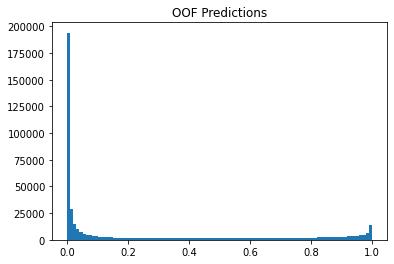

In [ ]:
# PLOT OOF PREDICTIONS
plt.hist(oof_xgb.oof_pred.values, bins=100)
plt.title('OOF Predictions')
plt.show()

In [ ]:
# CLEAR VRAM, RAM FOR INFERENCE BELOW
del oof_xgb, oof
_ = gc.collect()

# Feature Importance

In [ ]:
import matplotlib.pyplot as plt

df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'xgb_feature_importance_v{VER}.csv',index=False)

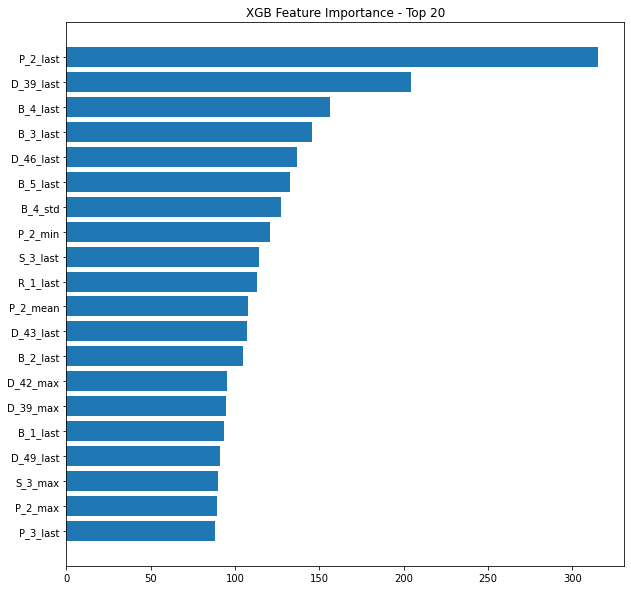

In [ ]:
NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Process and Feature Engineer Test Data


In [ ]:
_ = gc.collect()

In [ ]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4
TEST_PATH = 'test.parquet'

print(f'Reading test data...')
test = read_file(path = TEST_PATH, usecols = ['customer_ID','S_2'])
test = handle_na(test,NAN_VALUE)
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

Reading test data...
shape of data: (11363762, 2)
We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[2841209, 2839857, 2842105, 2840591]


In [ ]:
os.chdir('/content/drive/MyDrive/Amex/parquet/')

# Infer Test

In [ ]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test = read_file(path = TEST_PATH)
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    test = process_and_feature_engineer(test,cat_features, num_features, growth)
    for m,k in col_added:
      test[f'{m}_{k}']= test[m]*test[k] 
    if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
    else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    
    # TEST DATA FOR XGB
    X_test = test[FEATURES]
    dtest = xgb.DMatrix(data=X_test)
    del test 
    del X_test
    gc.collect()

    # INFER XGB MODELS ON TEST DATA
    model = xgb.Booster()
    model.load_model(f'XGB_v{VER}_fold0.xgb')
    #model.load_model('XGB_full.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'XGB_v{VER}_fold{fold}.xgb')
        #model.load_model(f'XGB_full.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del dtest, model
    _ = gc.collect()


Reading test data...
shape of data: (11363762, 190)
=> Test part 1 has shape (2841209, 190)
shape after engineering (231155, 1114)

Reading test data...
shape of data: (11363762, 190)
=> Test part 2 has shape (2839857, 190)
shape after engineering (231155, 1114)

Reading test data...
shape of data: (11363762, 190)
=> Test part 3 has shape (2842105, 190)
shape after engineering (231155, 1114)

Reading test data...
shape of data: (11363762, 190)
=> Test part 4 has shape (2840591, 190)
shape after engineering (231156, 1114)


# Create Submission CSV

In [ ]:
# WRITE SUBMISSION FILE
#test_preds = np.concatenate(test_preds).to_numpy()
test = pd.DataFrame(index=customers,data={'prediction':[test_preds]})
sub = pd.read_csv('/content/drive/MyDrive/Amex/parquet/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test['prediction'], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

TypeError: ignored

In [ ]:
sub.to_csv(f'/content/drive/My Drive/Amex/parquet/XGB Baseline/submission.csv',index=False)

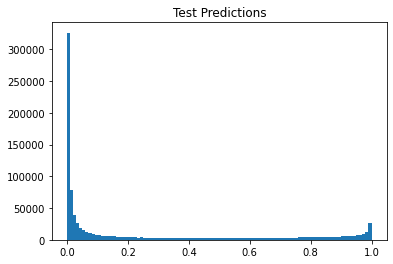

In [ ]:
# PLOT PREDICTIONS
plt.hist(sub.to_pandas().prediction, bins=100)
plt.title('Test Predictions')
plt.show()

Feature Engineering

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state=100,
                                                    stratify=y)